In [1]:
%%bash
#pip install -e /home/jovyan/Tools/dea_tools
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs

Looking in indexes: https://packages.dea.ga.gov.au/


In [2]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import rioxarray
import scipy.optimize as opt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools.waterbodies import get_time_series, get_waterbody
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from dea_tools import filters

#import wofs.wofls
#from wofs import classifier, filters
import rioxarray


In [3]:
# Set up the datacube:
dc = datacube.Datacube(app="WaterbodyTimeSeriesS2")

In [4]:
geohash = "r1uqwu1tj_v3" # Lake Victoria
#ts_sa = get_time_series(geohash=geohash)

In [5]:
# Load the waterbody shape:
shape = get_waterbody(geohash)

time_period = ("2015-08-01", "2017-01-01")

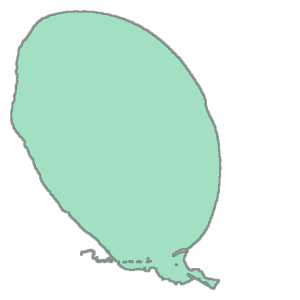

In [6]:
shape.geometry[0]

In [7]:
ds = load_ard(
    dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    resolution=(-10, 10),
    output_crs="EPSG:3577",
    min_gooddata=0.9,
    geopolygon=datacube.utils.geometry.Geometry(
        shape.geometry[0].buffer(100), crs="EPSG:3577"
    ),
    time=time_period,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 31 out of 82 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 31 time steps


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


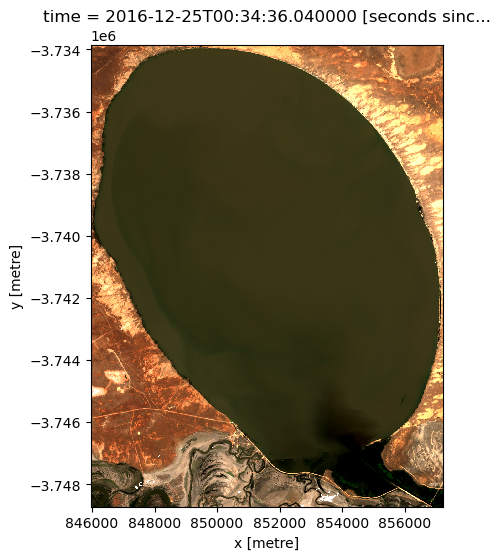

In [8]:
rgb(ds.isel(time=-1))

## Run WOfS

In [9]:
from dea_tools.S2_wofls import MASKED_CLOUD, MASKED_CLOUD_SHADOW, NO_DATA

In [10]:
# Open the DEM, which is in EPSG:3577
dem = rioxarray.open_rasterio("lakevictoria.tif")

# define nodata values https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html
nodata = dem.rio.nodata

In [11]:
# Screen out no-data
dem = dem.where(dem != nodata)
#print(dem)
print(nodata)

-3.4028235e+38


In [12]:
# Set zero pixels (water) to the minimum to avoid edge effects in WOfS terrain shadows
dem.isel(band=0).values[(dem == 0).values[0]] = dem.where(dem > 0).min()

In [13]:
# Convert into an xarray dataset for WOfS
dem = xr.Dataset({"elevation": dem.isel(band=0)})

In [14]:
# Set nodata attrs
ds.attrs["nodata"] = np.nan
for band in ds.variables:
    ds[band].attrs["nodata"] = np.nan

In [15]:
# and the CRS
dem.attrs["crs"] = "EPSG:3577"

In [16]:
# reproject the DEM
transform, width, height = rasterio.warp.calculate_default_transform(
    "EPSG:3577", "EPSG:3577", dem.rio.width, dem.rio.height, *dem.rio.bounds()
)

In [17]:
dem_reproj = rasterio.warp.reproject(
    source=dem.elevation,
    src_transform=dem.rio.transform(),
    src_crs=dem.crs,
    destination=ds.rename({"nbart_blue": "elevation"}).elevation.isel(time=0).copy(),
    dst_transform=ds.rio.transform(),
    dst_crs=ds.crs,
    resampling=rasterio.warp.Resampling.bilinear,
)[0]

In [18]:
# create the cloud mask
#fmask = ds.oa_fmask
#print(fmask)
#shape = fmask.shape
#print(shape)

In [19]:
#test = ds.isel(time=0)
#ard = test

#fmask = test.oa_fmask
#print(fmask)
#shape = fmask.shape
#print(shape)

In [20]:
from dea_tools.plotting import plot_wo
from dea_tools.S2_wofls import woffles_ard

In [21]:
s2_wofls = []
for i in tqdm(range(len(ds.time))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s2_wofls_ = woffles_ard(
            ds.rename(
                {
                    "nbart_nir_1": "nbart_nir",
                    "nbart_swir_2": "nbart_swir_1",
                    "nbart_swir_3": "nbart_swir_2",
                }
            ).isel(time=i),
            xr.Dataset({"elevation": dem_reproj}, attrs={"crs": "EPSG:3577"}),
        )
        s2_wofls.append(s2_wofls_)

  0%|          | 0/31 [00:00<?, ?it/s]

NameError: name 'solar_vector' is not defined